# **Modelo de Previsão de Preços de Imóveis em São Paulo**

Importação das principais bibliotecas e da base de dados

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("argonalyst/sao-paulo-real-estate-sale-rent-april-2019")

print("Path to dataset files:", path)

In [195]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import geopandas as gpd
import contextily as ctx

### 1 - Análise Exploratória da Base de Dados e Tratamento de Dados

In [196]:
# Caminho do arquivo com barras duplas (ou use raw string com prefixo 'r')
caminho_csv = r'C:\Users\luuka\.cache\kagglehub\datasets\argonalyst\sao-paulo-real-estate-sale-rent-april-2019\versions\1\sao-paulo-properties-april-2019.csv'

# Lendo o arquivo
df = pd.read_csv(caminho_csv)

In [197]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


In [198]:
# Visualização da distribuição por apartamentos por quartos
px.scatter(df, x='Rooms', y='Price')

In [199]:
df['Negotiation Type'].unique()

array(['rent', 'sale'], dtype=object)

In [200]:
df['District'].unique()

array(['Artur Alvim/São Paulo', 'Belém/São Paulo', 'Cangaíba/São Paulo',
       'Carrão/São Paulo', 'Cidade Líder/São Paulo',
       'Cidade Tiradentes/São Paulo', 'Ermelino Matarazzo/São Paulo',
       'Iguatemi/São Paulo', 'Itaim Paulista/São Paulo',
       'Itaquera/São Paulo', 'Jardim Helena/São Paulo',
       'José Bonifácio/São Paulo', 'Lajeado/São Paulo',
       'Parque do Carmo/São Paulo', 'Penha/São Paulo',
       'Ponte Rasa/São Paulo', 'Sapopemba/São Paulo',
       'São Lucas/São Paulo', 'São Mateus/São Paulo',
       'São Miguel/São Paulo', 'São Rafael/São Paulo',
       'Tatuapé/São Paulo', 'Vila Curuçá/São Paulo',
       'Vila Formosa/São Paulo', 'Vila Jacuí/São Paulo',
       'Vila Matilde/São Paulo', 'Vila Prudente/São Paulo',
       'Cambuci/São Paulo', 'Campo Belo/São Paulo',
       'Campo Grande/São Paulo', 'Campo Limpo/São Paulo',
       'Capão Redondo/São Paulo', 'Cidade Ademar/São Paulo',
       'Cidade Dutra/São Paulo', 'Cursino/São Paulo', 'Grajaú/São Paulo',
  

In [201]:
mapeamento_regioes = {
    # Zona Leste
    'Artur Alvim/São Paulo': 'Zona Leste',
    'Cangaíba/São Paulo': 'Zona Leste',
    'Carrão/São Paulo': 'Zona Leste',
    'Cidade Líder/São Paulo': 'Zona Leste',
    'Cidade Tiradentes/São Paulo': 'Zona Leste',
    'Ermelino Matarazzo/São Paulo': 'Zona Leste',
    'Itaim Paulista/São Paulo': 'Zona Leste',
    'Itaquera/São Paulo': 'Zona Leste',
    'Jardim Helena/São Paulo': 'Zona Leste',
    'José Bonifácio/São Paulo': 'Zona Leste',
    'Lajeado/São Paulo': 'Zona Leste',
    'Parque do Carmo/São Paulo': 'Zona Leste',
    'Ponte Rasa/São Paulo': 'Zona Leste',
    'São Mateus/São Paulo': 'Zona Leste',
    'São Miguel/São Paulo': 'Zona Leste',
    'São Rafael/São Paulo': 'Zona Leste',
    'Vila Curuçá/São Paulo': 'Zona Leste',
    'Vila Formosa/São Paulo': 'Zona Leste',
    'Aricanduva/São Paulo': 'Zona Leste',
    'Guaianazes/São Paulo': 'Zona Leste',
    'Penha/São Paulo': 'Zona Leste',
    'Tatuapé/São Paulo': 'Zona Leste',
    'Vila Matilde/São Paulo': 'Zona Leste',
    'Mooca/São Paulo': 'Zona Leste',
    'Belém/São Paulo': 'Zona Leste',
    'Água Rasa/São Paulo': 'Zona Leste',
    'Sapopemba/São Paulo': 'Zona Leste',
    'São Lucas/São Paulo': 'Zona Leste',
    'Vila Jacuí/São Paulo': 'Zona Leste',
    'Vila Prudente/São Paulo': 'Zona Leste',
    'Iguatemi/São Paulo': 'Zona Leste',
    
    # Zona Sul
    'Campo Belo/São Paulo': 'Zona Sul',
    'Campo Grande/São Paulo': 'Zona Sul',
    'Campo Limpo/São Paulo': 'Zona Sul',
    'Capão Redondo/São Paulo': 'Zona Sul',
    'Cidade Ademar/São Paulo': 'Zona Sul',
    'Cidade Dutra/São Paulo': 'Zona Sul',
    'Grajaú/São Paulo': 'Zona Sul',
    'Ipiranga/São Paulo': 'Zona Sul',
    'Itaim Bibi/São Paulo': 'Zona Sul',
    'Jabaquara/São Paulo': 'Zona Sul',
    'Jardim Ângela/São Paulo': 'Zona Sul',
    'Jardim Paulista/São Paulo': 'Zona Sul',
    'Moema/São Paulo': 'Zona Sul',
    'Morumbi/São Paulo': 'Zona Sul',
    'Sacomã/São Paulo': 'Zona Sul',
    'Santo Amaro/São Paulo': 'Zona Sul',
    'Saúde/São Paulo': 'Zona Sul',
    'Socorro/São Paulo': 'Zona Sul',
    'Vila Andrade/São Paulo': 'Zona Sul',
    'Vila Mariana/São Paulo': 'Zona Sul',
    'Vila Sônia/São Paulo': 'Zona Sul',
    'Brooklin/São Paulo': 'Zona Sul',
    'Vila Olimpia/São Paulo': 'Zona Sul',
    'Pedreira/São Paulo': 'Zona Sul',
    'Cursino/São Paulo': 'Zona Sul',
    'Cambuci/São Paulo': 'Zona Sul',
    'Jardim São Luis/São Paulo': 'Zona Sul',
    
    # Zona Oeste
    'Alto de Pinheiros/São Paulo': 'Zona Oeste',
    'Butantã/São Paulo': 'Zona Oeste',
    'Jaguaré/São Paulo': 'Zona Oeste',
    'Lapa/São Paulo': 'Zona Oeste',
    'Perdizes/São Paulo': 'Zona Oeste',
    'Pinheiros/São Paulo': 'Zona Oeste',
    'Vila Leopoldina/São Paulo': 'Zona Oeste',
    'Vila Madalena/São Paulo': 'Zona Oeste',
    'Raposo Tavares/São Paulo': 'Zona Oeste',
    'Rio Pequeno/São Paulo': 'Zona Oeste',
    'Pirituba/São Paulo': 'Zona Oeste',
    'Perus/São Paulo': 'Zona Oeste',
    'Anhanguera/São Paulo': 'Zona Oeste',
    'Jaraguá/São Paulo': 'Zona Oeste',
    'São Domingos/São Paulo': 'Zona Oeste',
    
    # Zona Norte
    'Casa Verde/São Paulo': 'Zona Norte',
    'Santana/São Paulo': 'Zona Norte',
    'Tucuruvi/São Paulo': 'Zona Norte',
    'Mandaqui/São Paulo': 'Zona Norte',
    'Tremembé/São Paulo': 'Zona Norte',
    'Vila Guilherme/São Paulo': 'Zona Norte',
    'Vila Maria/São Paulo': 'Zona Norte',
    'Jaçanã/São Paulo': 'Zona Norte',
    'Brasilândia/São Paulo': 'Zona Norte',
    'Freguesia do Ó/São Paulo': 'Zona Norte',
    'Limão/São Paulo': 'Zona Norte',
    'Cachoeirinha/São Paulo': 'Zona Norte',
    'Medeiros/São Paulo': 'Zona Norte',
    
    # Centro (se necessário)
    'Barra Funda/São Paulo': 'Centro',
    'Bela Vista/São Paulo': 'Centro',
    'Bom Retiro/São Paulo': 'Centro',
    'Brás/São Paulo': 'Centro',
    'Consolação/São Paulo': 'Centro',
    'Liberdade/São Paulo': 'Centro',
    'República/São Paulo': 'Centro',
    'Santa Cecília/São Paulo': 'Centro',
    'Sé/São Paulo': 'Centro',
    'Pari/São Paulo': 'Centro'
}


In [202]:
df['Regiao'] = df['District'].map(mapeamento_regioes)

In [203]:
df['Regiao'] 

0        Zona Leste
1        Zona Leste
2        Zona Leste
3        Zona Leste
4        Zona Leste
            ...    
13635      Zona Sul
13636      Zona Sul
13637      Zona Sul
13638      Zona Sul
13639      Zona Sul
Name: Regiao, Length: 13640, dtype: object

In [204]:
df.describe()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
count,1.364000e+04,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.00000,13640.000000,13640.000000,13640.000000
mean,2.877378e+05,689.882331,84.373900,2.312023,2.073680,0.980792,1.393182,0.354179,0.146774,0.51217,0.015616,-22.077047,-43.597088
std,5.908214e+05,757.649363,58.435676,0.777461,0.961803,0.834891,0.829932,0.478281,0.353894,0.49987,0.123988,5.866633,11.487288
min,4.800000e+02,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-46.749039,-58.364352
25%,1.858750e+03,290.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,-23.594552,-46.681671
50%,8.100000e+03,500.000000,65.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000,-23.552813,-46.637255
75%,3.600000e+05,835.000000,94.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.00000,0.000000,-23.517640,-46.560040
max,1.000000e+07,9500.000000,880.000000,10.000000,8.000000,6.000000,9.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000


In [205]:
px.density_mapbox(df, lat="Latitude", lon="Longitude", radius=10, zoom=10, mapbox_style="open-street-map")

In [206]:
df[["bairro", "municipio"]] = df["District"].str.split("/", expand=True)
df = df[df["New"] == 0]
df = df[df['Negotiation Type'] == 'sale']
df.drop(['New', 'Negotiation Type','Property Type'], axis=1, inplace=True)

In [207]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,District,Latitude,Longitude,Regiao,bairro,municipio
4901,732600,1000,74,1,2,1,2,1,0,1,Vila Madalena/São Paulo,-23.552129,-46.692244,Zona Oeste,Vila Madalena,São Paulo
4902,1990000,2400,164,4,5,2,3,1,1,1,Vila Madalena/São Paulo,-23.551613,-46.699106,Zona Oeste,Vila Madalena,São Paulo
4904,1680000,1580,155,3,5,3,2,1,0,1,Vila Madalena/São Paulo,-23.552590,-46.691104,Zona Oeste,Vila Madalena,São Paulo
4905,1200000,900,56,2,2,1,2,0,1,1,Vila Madalena/São Paulo,-23.553087,-46.697890,Zona Oeste,Vila Madalena,São Paulo
4906,1950000,2207,122,3,2,1,2,1,0,1,Vila Madalena/São Paulo,-23.558541,-46.692320,Zona Oeste,Vila Madalena,São Paulo


In [208]:
# Histograma interativo com Plotly
fig = px.histogram(
    df,
    x="Price",                  # Coluna para o eixo X
    nbins=200,                    # Número de intervalos
    title="Histograma de Valores (São Paulo/SP)",  # Título
    labels={"valor": "Valor"},   # Rótulo do eixo X
    opacity=0.7,                # Transparência das barras
    color_discrete_sequence=["#1f77b4"],  # Cor das barras (azul)
    template="plotly_white"     # Estilo do gráfico
)

# Personalizar layout
fig.update_layout(
    bargap=0.1,                 # Espaço entre barras
    xaxis_title="Valor",        # Título do eixo X
    yaxis_title="Frequência",   # Título do eixo Y
    hovermode="x",              # Mostrar informações ao passar o mouse
    showlegend=False            # Ocultar legenda (não necessária para histogramas simples)
)

# Exibir o gráfico
fig.show()

In [209]:
# 1. Subplots para histogramas (Price e Size)
fig = make_subplots(
    rows=1, cols=2,  # 1 linha, 2 colunas
    subplot_titles=("Distribuição de Preços", "Distribuição de Metragem"),
    horizontal_spacing=0.15
)

# Histograma de Preços
fig.add_trace(
    go.Histogram(x=df["Price"], nbinsx=100, name="Preço", marker_color="#1f77b4"),
    row=1, col=1
)

# Histograma do tamanho do apartamento
fig.add_trace(
    go.Histogram(x=df["Size"], nbinsx=100, name="Metragem", marker_color="#ff7f0e"),
    row=1, col=2
)

# Atualizar layout dos subplots
fig.update_layout(
    title_text="Análise de Imóveis: Preço e Metragem",
    showlegend=False,
    height=400
)

# 2. Gráfico agrupado por bairro (usando Plotly Express)
fig_bairro = px.bar(
    df.groupby("bairro", as_index=False)["Price"].mean(),
    x="bairro",
    y="Price",
    title="Preço Médio por Bairro",
    color="bairro",
    labels={"Price": "Preço Médio", "Neighborhood": "Bairro"}
)
fig_bairro.update_layout(height=500, showlegend=False)

# Exibir os gráficos
fig.show()
fig_bairro.show()


### 1 - Pré-processamento dos Dados Consolidados

In [210]:
df.head(100)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,District,Latitude,Longitude,Regiao,bairro,municipio
4901,732600,1000,74,1,2,1,2,1,0,1,Vila Madalena/São Paulo,-23.552129,-46.692244,Zona Oeste,Vila Madalena,São Paulo
4902,1990000,2400,164,4,5,2,3,1,1,1,Vila Madalena/São Paulo,-23.551613,-46.699106,Zona Oeste,Vila Madalena,São Paulo
4904,1680000,1580,155,3,5,3,2,1,0,1,Vila Madalena/São Paulo,-23.552590,-46.691104,Zona Oeste,Vila Madalena,São Paulo
4905,1200000,900,56,2,2,1,2,0,1,1,Vila Madalena/São Paulo,-23.553087,-46.697890,Zona Oeste,Vila Madalena,São Paulo
4906,1950000,2207,122,3,2,1,2,1,0,1,Vila Madalena/São Paulo,-23.558541,-46.692320,Zona Oeste,Vila Madalena,São Paulo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,1162756,0,95,3,3,1,2,1,0,1,Vila Olimpia/São Paulo,-23.604074,-46.675494,Zona Sul,Vila Olimpia,São Paulo
5004,1600000,0,112,3,3,1,2,1,0,1,Vila Olimpia/São Paulo,-23.604197,-46.678332,Zona Sul,Vila Olimpia,São Paulo
5005,775000,937,98,3,2,1,1,0,0,0,Vila Olimpia/São Paulo,-23.602791,-46.675565,Zona Sul,Vila Olimpia,São Paulo
5006,8000000,0,278,4,5,3,5,1,0,1,Vila Olimpia/São Paulo,-23.596469,-46.680587,Zona Sul,Vila Olimpia,São Paulo


In [211]:
df.drop(['District'], axis=1, inplace=True)

In [212]:
df.drop(['municipio'], axis=1, inplace=True)

In [213]:
df.drop(['Condo'], axis=1, inplace=True)

In [214]:
df.drop(['Furnished'], axis=1, inplace=True)

In [215]:
df.drop(['Elevator'], axis=1, inplace=True)

In [216]:
df.drop(['Latitude'], axis=1, inplace=True)

In [217]:
df.drop(['Longitude'], axis=1, inplace=True)

In [218]:
df.head()

,Price,Size,Rooms,Toilets,Suites,Parking,Swimming Pool,Regiao,bairro
4901,732600,74,1,2,1,2,1,Zona Oeste,Vila Madalena
4902,1990000,164,4,5,2,3,1,Zona Oeste,Vila Madalena
4904,1680000,155,3,5,3,2,1,Zona Oeste,Vila Madalena
4905,1200000,56,2,2,1,2,1,Zona Oeste,Vila Madalena
4906,1950000,122,3,2,1,2,1,Zona Oeste,Vila Madalena


In [219]:
#Selecionar features relevantes
features = ["Size", "Rooms", "Toilets", "Suites", "Parking"]
target = "Price"

# Tratamento de valores ausentes
df.dropna(subset=['Price', 'Size'], inplace=True)

### 2. Engenharia de Features com Foco em Localização

In [220]:
# Criar preço por m²
df['preco_m2'] = df['Price'] / df['Size']

# Calcular médias por região para features de localização
df['media_preco_bairro'] = df.groupby('bairro')['preco_m2'].transform('mean')
df['media_preco_regiao'] = df.groupby('Regiao')['preco_m2'].transform('mean')

In [221]:
df.head()

,Price,Size,Rooms,Toilets,Suites,Parking,Swimming Pool,Regiao,bairro,preco_m2,media_preco_bairro,media_preco_regiao
4901,732600,74,1,2,1,2,1,Zona Oeste,Vila Madalena,9900.000000,12154.000075,8856.392117
4902,1990000,164,4,5,2,3,1,Zona Oeste,Vila Madalena,12134.146341,12154.000075,8856.392117
4904,1680000,155,3,5,3,2,1,Zona Oeste,Vila Madalena,10838.709677,12154.000075,8856.392117
4905,1200000,56,2,2,1,2,1,Zona Oeste,Vila Madalena,21428.571429,12154.000075,8856.392117
4906,1950000,122,3,2,1,2,1,Zona Oeste,Vila Madalena,15983.606557,12154.000075,8856.392117


In [222]:
# Codificar hierarquia geográfica (Distrito > Região)
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[sorted(df['Regiao'].unique()), 
                         sorted(df['bairro'].unique())])
df[['REGIAO_ENC', 'DISTRITO_ENC']] = encoder.fit_transform(df[['Regiao', 'bairro']])

# Features finais para o modelo
model_features = [
    'Size', 'Rooms', 'Parking', 'Toilets', 'Suites', 'Regiao', 'bairro'
]

### 3. Pipeline de Modelagem com XGBoost

In [223]:

# Divisão dos dados
X = df[model_features]
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [224]:
# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Size']),
        ('cat', OneHotEncoder(), ['Regiao', 'bairro'])
    ],
    remainder='passthrough'
)

In [225]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(), ['Size']),
                                ('cat', OneHotEncoder(), ['Regiao', 'bairro'])])

In [226]:
# Modelo XGBoost com otimização de hiperparâmetros
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    ))
])

In [227]:
# Treinamento
model.fit(X_train, y_train)

c:\Users\luuka\anaconda3\envs\streamlit\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Size']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Regiao', 'bairro'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [228]:
df.head()

,Price,Size,Rooms,Toilets,Suites,Parking,Swimming Pool,Regiao,bairro,preco_m2,media_preco_bairro,media_preco_regiao,REGIAO_ENC,DISTRITO_ENC
4901,732600,74,1,2,1,2,1,Zona Oeste,Vila Madalena,9900.000000,12154.000075,8856.392117,3.0,88.0
4902,1990000,164,4,5,2,3,1,Zona Oeste,Vila Madalena,12134.146341,12154.000075,8856.392117,3.0,88.0
4904,1680000,155,3,5,3,2,1,Zona Oeste,Vila Madalena,10838.709677,12154.000075,8856.392117,3.0,88.0
4905,1200000,56,2,2,1,2,1,Zona Oeste,Vila Madalena,21428.571429,12154.000075,8856.392117,3.0,88.0
4906,1950000,122,3,2,1,2,1,Zona Oeste,Vila Madalena,15983.606557,12154.000075,8856.392117,3.0,88.0


In [229]:
# Avaliação
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"mae: {mae:.2f}")
print(f"R²: {r2:.4f}")

mae: 107735.52
R²: 0.9015


In [230]:
# Avaliação
y_pred = model.predict(X_test)
mae = np.sqrt(mean_absolute_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MAE: 328.23
R²: 0.9015


### 4. Análise da Importância de Features

In [231]:
# Extrair importância das features
feature_importances = model.named_steps['regressor'].feature_importances_

In [232]:
# Obter nomes das features após o pré-processamento
cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['Regiao', 'bairro'])
all_features = ['Size'] + list(cat_features) + model_features[3:]

In [233]:
# Criar DataFrame com importâncias
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

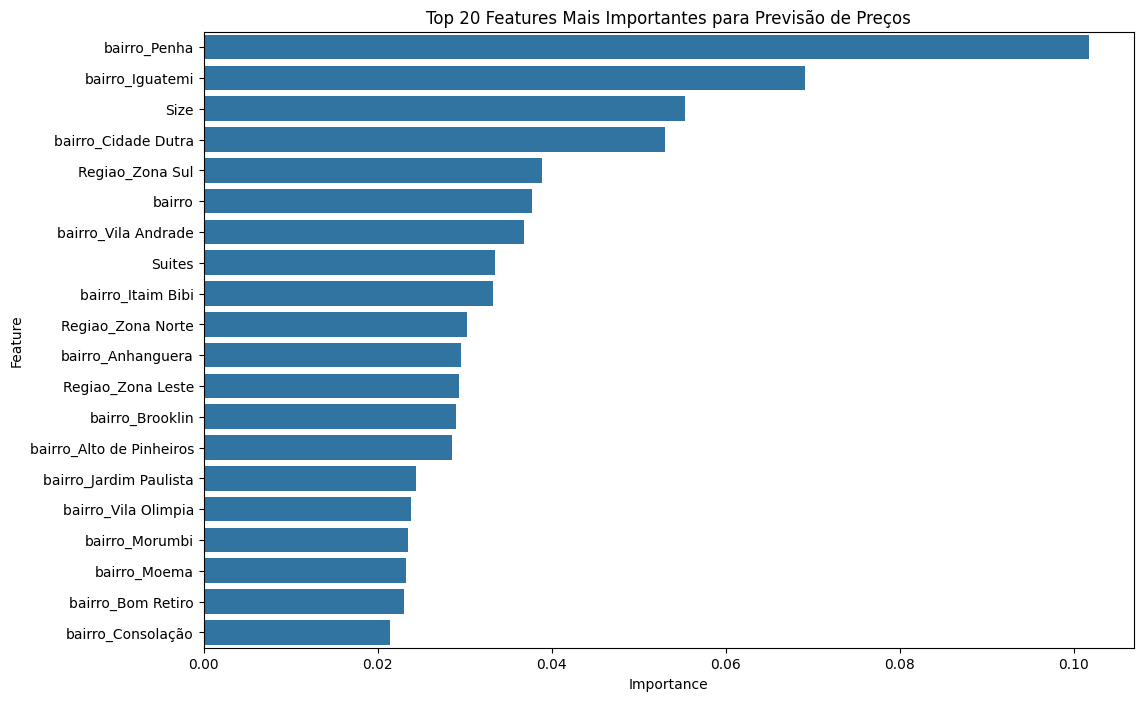

In [234]:
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Features Mais Importantes para Previsão de Preços')
plt.show()

In [235]:
import joblib

# Salvar o modelo
joblib.dump(model, r'C:\Users\luuka\Downloads\modelo_precos_sp.pkl')

['C:\\Users\\luuka\\Downloads\\modelo_precos_sp.pkl']

In [236]:
import joblib
import pandas as pd

def prever_preco(Size, Rooms, Parking, bairro, Suites, Toilets, Regiao):
    """
    Função para prever preços de imóveis com todos os parâmetros necessários
    
    Parâmetros obrigatórios:
    - Size: Área construída em m² (float)
    - Rooms: Número de quartos (int)
    - Parking: Vagas de garagem (int)
    - bairro: Nome do bairro (str)
    - Suites: Número de suítes (int)
    - Toilets: Número de banheiros (int)
    
    Parâmetro opcional:
    - Regiao: Região da cidade (str) - pode ser None
    """
    try:
        # Carregar modelo
        model = joblib.load(r'C:\Users\luuka\Downloads\modelo_precos_sp.pkl')
        
        # Criar DataFrame com todos os parâmetros
        input_data = pd.DataFrame({
            'Size': [Size],
            'Rooms': [Rooms],
            'Parking': [Parking],
            'bairro': [bairro],
            'Suites': [Suites],
            'Toilets': [Toilets],
            'Regiao': [Regiao]
        })
        
        
        # Calcular média do bairro
        input_data['MEDIA_PRECO_DISTRITO'] = df[df['bairro'] == bairro]['preco_m2'].mean()
        
        # Fazer previsão
        return model.predict(input_data)[0]
    
    except Exception as e:
        print(f"Erro na previsão: {str(e)}")
        return None

In [237]:
prever_preco

<function __main__.prever_preco(Size, Rooms, Parking, bairro, Suites, Toilets, Regiao)>

In [238]:
prever_preco(59, 2, 1, 'Ipiranga', 1, 2, 'Zona Sul')

393336.66

In [ ]:
mapeamento_regioes = {
    # Zona Leste
    'Artur Alvim': 'Zona Leste',
    'Cangaíba': 'Zona Leste',
    'Carrão': 'Zona Leste',
    'Cidade Líder': 'Zona Leste',
    'Cidade Tiradentes': 'Zona Leste',
    'Ermelino Matarazzo': 'Zona Leste',
    'Itaim Paulista': 'Zona Leste',
    'Itaquera': 'Zona Leste',
    'Jardim Helena': 'Zona Leste',
    'José Bonifácio': 'Zona Leste',
    'Lajeado': 'Zona Leste',
    'Parque do Carmo': 'Zona Leste',
    'Ponte Rasa': 'Zona Leste',
    'São Mateus': 'Zona Leste',
    'São Miguel': 'Zona Leste',
    'São Rafael': 'Zona Leste',
    'Vila Curuçá': 'Zona Leste',
    'Vila Formosa': 'Zona Leste',
    'Aricanduva': 'Zona Leste',
    'Guaianazes': 'Zona Leste',
    'Penha': 'Zona Leste',
    'Tatuapé': 'Zona Leste',
    'Vila Matilde': 'Zona Leste',
    'Mooca': 'Zona Leste',
    'Belém': 'Zona Leste',
    'Água Rasa': 'Zona Leste',
    'Sapopemba': 'Zona Leste',
    'São Lucas': 'Zona Leste',
    'Vila Jacuí': 'Zona Leste',
    'Vila Prudente': 'Zona Leste',
    'Iguatemi': 'Zona Leste',
    
    # Zona Sul
    'Campo Belo': 'Zona Sul',
    'Campo Grande': 'Zona Sul',
    'Campo Limpo': 'Zona Sul',
    'Capão Redondo': 'Zona Sul',
    'Cidade Ademar': 'Zona Sul',
    'Cidade Dutra': 'Zona Sul',
    'Grajaú': 'Zona Sul',
    'Ipiranga': 'Zona Sul',
    'Itaim Bibi': 'Zona Sul',
    'Jabaquara': 'Zona Sul',
    'Jardim Ângela': 'Zona Sul',
    'Jardim Paulista': 'Zona Sul',
    'Moema': 'Zona Sul',
    'Morumbi': 'Zona Sul',
    'Sacomã': 'Zona Sul',
    'Santo Amaro': 'Zona Sul',
    'Saúde': 'Zona Sul',
    'Socorro': 'Zona Sul',
    'Vila Andrade': 'Zona Sul',
    'Vila Mariana': 'Zona Sul',
    'Vila Sônia': 'Zona Sul',
    'Brooklin': 'Zona Sul',
    'Vila Olimpia': 'Zona Sul',
    'Pedreira': 'Zona Sul',
    'Cursino': 'Zona Sul',
    'Cambuci': 'Zona Sul',
    'Jardim São Luis': 'Zona Sul',
    
    # Zona Oeste
    'Alto de Pinheiros': 'Zona Oeste',
    'Butantã': 'Zona Oeste',
    'Jaguaré': 'Zona Oeste',
    'Lapa': 'Zona Oeste',
    'Perdizes': 'Zona Oeste',
    'Pinheiros': 'Zona Oeste',
    'Vila Leopoldina': 'Zona Oeste',
    'Vila Madalena': 'Zona Oeste',
    'Raposo Tavares': 'Zona Oeste',
    'Rio Pequeno': 'Zona Oeste',
    'Pirituba': 'Zona Oeste',
    'Perus': 'Zona Oeste',
    'Anhanguera': 'Zona Oeste',
    'Jaraguá': 'Zona Oeste',
    'São Domingos': 'Zona Oeste',
    
    # Zona Norte
    'Casa Verde': 'Zona Norte',
    'Santana': 'Zona Norte',
    'Tucuruvi': 'Zona Norte',
    'Mandaqui': 'Zona Norte',
    'Tremembé': 'Zona Norte',
    'Vila Guilherme': 'Zona Norte',
    'Vila Maria': 'Zona Norte',
    'Jaçanã': 'Zona Norte',
    'Brasilândia': 'Zona Norte',
    'Freguesia do Ó': 'Zona Norte',
    'Limão': 'Zona Norte',
    'Cachoeirinha': 'Zona Norte',
    'Medeiros': 'Zona Norte',
    
    # Centro
    'Barra Funda': 'Centro',
    'Bela Vista': 'Centro',
    'Bom Retiro': 'Centro',
    'Brás': 'Centro',
    'Consolação': 'Centro',
    'Liberdade': 'Centro',
    'República': 'Centro',
    'Santa Cecília': 'Centro',
    'Sé': 'Centro',
    'Pari': 'Centro'
}

def previsao_interativa():
    """Função interativa que determina a região automaticamente pelo bairro"""
    
    print("\n=== PREVISÃO DE PREÇOS DE IMÓVEIS EM SÃO PAULO ===")
    print("Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):\n")
    
    try:
        # Coletar dados do imóvel
        print("▌ DADOS DO IMÓVEL ▌")
        Size = input("• Área construída (m²): ")
        if Size.lower() == 'sair': return
        Size = float(Size)
        
        Rooms = input("• Número de quartos: ")
        if Rooms.lower() == 'sair': return
        Rooms = int(Rooms)
        
        Suites = input("• Número de suítes: ")
        if Suites.lower() == 'sair': return
        Suites = int(Suites)
        
        Toilets = input("• Número de banheiros: ")
        if Toilets.lower() == 'sair': return
        Toilets = int(Toilets)
        
        Parking = input("• Vagas de garagem: ")
        if Parking.lower() == 'sair': return
        Parking = int(Parking)
        
        # Coletar localização com tratamento especial
        print("\n▌ LOCALIZAÇÃO ▌")
        while True:
            bairro = input("• Bairro (ex: 'Pinheiros', 'Moema'): ").strip().title()
            if bairro.lower() == 'sair': return
            
            # Verificar se o bairro está no mapeamento
            Regiao = mapeamento_regioes.get(bairro, None)
            
            if Regiao is not None:
                break
            else:
                print(f"Bairro '{bairro}' não encontrado. Por favor, digite novamente.")
                print("Dica: Digite apenas o nome do bairro (ex: 'Tatuapé' em vez de 'Tatuapé/São Paulo')")
        
        print(f"\nℹ️ Região determinada automaticamente: {Regiao}")
        
        # Fazer previsão
        preco = prever_preco(
            Size=Size,
            Rooms=Rooms,
            Parking=Parking,
            bairro=bairro,
            Suites=Suites,
            Toilets=Toilets,
            Regiao=Regiao
        )
        
        # Mostrar resultado completo
        if preco is not None:
            print("\n" + "="*60)
            print("📋 RESUMO DOS DADOS INFORMADOS")
            print("-"*60)
            print(f"▪ Área construída: {Size} m²")
            print(f"▪ Quartos: {Rooms} (Suítes: {Suites})")
            print(f"▪ Banheiros: {Toilets}")
            print(f"▪ Vagas: {Parking}")
            print(f"▪ Localização: {bairro} - {Regiao}")
            
            print("\n💲 RESULTADO DA PREVISÃO")
            print("-"*60)
            print(f"Valor estimado: R$ {preco:,.2f}")
            print(f"Faixa sugerida: R$ {preco*0.85:,.2f} a R$ {preco*1.15:,.2f}")
            print("="*60)
        else:
            print("\nNão foi possível calcular a previsão.")
            
    except ValueError:
        print("\nErro: Por favor, digite valores numéricos nos campos solicitados.")
    except Exception as e:
        print(f"\nOcorreu um erro: {str(e)}")

# Instruções para uso:
print("\nINSTRUÇÕES:")
print("1. Digite apenas o nome do bairro (sem '/São Paulo')")
print("2. O sistema identificará automaticamente a região")
print("3. Digite 'sair' a qualquer momento para cancelar\n")

# Exemplo de uso:
previsao_interativa()


INSTRUÇÕES:
1. Digite apenas o nome do bairro (sem '/São Paulo')
2. O sistema identificará automaticamente a região
3. Digite 'sair' a qualquer momento para cancelar


=== PREVISÃO DE PREÇOS DE IMÓVEIS EM SÃO PAULO ===
Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):

▌ DADOS DO IMÓVEL ▌

▌ LOCALIZAÇÃO ▌

ℹ️ Região determinada automaticamente: Zona Oeste

📋 RESUMO DOS DADOS INFORMADOS
------------------------------------------------------------
▪ Área construída: 50.0 m²
▪ Quartos: 2 (Suítes: 1)
▪ Banheiros: 2
▪ Vagas: 1
▪ Localização: Pinheiros - Zona Oeste

💲 RESULTADO DA PREVISÃO
------------------------------------------------------------
Valor estimado: R$ 607,956.56
Faixa sugerida: R$ 516,763.08 a R$ 699,150.05


In [253]:
def previsao_interativa():
    """Função interativa que determina a região automaticamente pelo bairro"""
    
    print("\n=== PREVISÃO DE PREÇOS DE IMÓVEIS EM SÃO PAULO ===")
    print("Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):\n")
    
    try:
        # Coletar dados do imóvel
        print("▌ DADOS DO IMÓVEL ▌")
        Size = input("• Área construída (m²): ")
        if Size.lower() == 'sair': return
        Size = float(Size)
        if Size <= 10:
            print("❌ Valor inválido. A área mínima deve ser maior que 10m². Digite novamente.")
            return
        Rooms = input("• Número de quartos: ")
        if Rooms.lower() == 'sair': return
        Rooms = int(Rooms)
        if Rooms < 1:
            print("❌ Valor inválido. O valor mínimo é 1.")
            return
        Suites = input("• Número de suítes: ")
        if Suites.lower() == 'sair': return
        Suites = int(Suites)
        
        Toilets = input("• Número de banheiros: ")
        if Toilets.lower() == 'sair': return
        Toilets = int(Toilets)
        if Toilets < 1:
            print("❌ Valor inválido. O valor mínimo é 1.")
            return
        Parking = input("• Vagas de garagem: ")
        if Parking.lower() == 'sair': return
        Parking = int(Parking)
        
        # Coletar localização com tratamento especial
        print("\n▌ LOCALIZAÇÃO ▌")
        while True:
            bairro = input("• Bairro (ex: 'Pinheiros', 'Moema'): ").strip().title()
            if bairro.lower() == 'sair': return
            
            # Verificar se o bairro está no mapeamento
            Regiao = mapeamento_regioes.get(bairro, None)
            
            if Regiao is not None:
                break
            else:
                print(f"Bairro '{bairro}' não encontrado. Por favor, digite novamente.")
                print("Dica: Digite apenas o nome do bairro (ex: 'Tatuapé' em vez de 'Tatuapé/São Paulo')")
        
        print(f"\nℹ️ Região determinada automaticamente: {Regiao}")
        
        # Fazer previsão
        preco = prever_preco(
            Size=Size,
            Rooms=Rooms,
            Parking=Parking,
            bairro=bairro,
            Suites=Suites,
            Toilets=Toilets,
            Regiao=Regiao
        )
        
        # Mostrar resultado completo
        if preco is not None:
            print("\n" + "="*60)
            print("📋 RESUMO DOS DADOS INFORMADOS")
            print("-"*60)
            print(f"▪ Área construída: {Size} m²")
            print(f"▪ Quartos: {Rooms} (Suítes: {Suites})")
            print(f"▪ Banheiros: {Toilets}")
            print(f"▪ Vagas: {Parking}")
            print(f"▪ Localização: {bairro} - {Regiao}")
            
            print("\n💲 RESULTADO DA PREVISÃO")
            print("-"*60)
            print(f"Valor estimado: R$ {preco:,.2f}")
            print(f"Faixa sugerida: R$ {preco*0.85:,.2f} a R$ {preco*1.15:,.2f}")
            print("="*60)
        else:
            print("\nNão foi possível calcular a previsão.")
            
    except ValueError:
        print("\nErro: Por favor, digite valores numéricos nos campos solicitados.")
    except Exception as e:
        print(f"\nOcorreu um erro: {str(e)}")

# Instruções para uso:
print("\nINSTRUÇÕES:")
print("1. Digite apenas o nome do bairro (sem '/São Paulo')")
print("2. O sistema identificará automaticamente a região")
print("3. Digite 'sair' a qualquer momento para cancelar\n")

# Exemplo de uso:
previsao_interativa()


INSTRUÇÕES:
1. Digite apenas o nome do bairro (sem '/São Paulo')
2. O sistema identificará automaticamente a região
3. Digite 'sair' a qualquer momento para cancelar


=== PREVISÃO DE PREÇOS DE IMÓVEIS EM SÃO PAULO ===
Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):

▌ DADOS DO IMÓVEL ▌

▌ LOCALIZAÇÃO ▌

ℹ️ Região determinada automaticamente: Zona Oeste

📋 RESUMO DOS DADOS INFORMADOS
------------------------------------------------------------
▪ Área construída: 70.0 m²
▪ Quartos: 2 (Suítes: 1)
▪ Banheiros: 2
▪ Vagas: 1
▪ Localização: Perdizes - Zona Oeste

💲 RESULTADO DA PREVISÃO
------------------------------------------------------------
Valor estimado: R$ 673,885.31
Faixa sugerida: R$ 572,802.52 a R$ 774,968.11
